In [1]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten, BatchNormalization, ZeroPadding2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import SGD
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import regularizers
import random

Using TensorFlow backend.


In [4]:
dataset  = pd.read_pickle(r'C:\Users\student\Desktop\MRS\datasetaugment.pickle')
for i,j in enumerate(dataset['mel_spec']):
    if len(j[0])!=434:
         dataset = dataset.drop(i,0)
del dataset['index']
dataset = dataset.sample(frac=1)
dataset = dataset.reset_index()
del dataset['index']
dataset['Genre'] = dataset['Genre'].replace('Classical','classical')
dataset['Genre'] = dataset['Genre'].replace('Country','country')
dataset['Genre'] = dataset['Genre'].replace('Electronic','electronic')
dataset['Genre'] = dataset['Genre'].replace('Hip-Hop','hip-hop')
dataset['Genre'] = dataset['Genre'].replace('Pop','pop')
dataset['Genre'] = dataset['Genre'].replace('Rock','rock')

In [5]:
train = dataset[dataset['Genre']!='country']
test = dataset[:1000]

In [6]:
print('Hip-Hop:   ',len(test[test['Genre']=='hip-hop']))
print('Pop:       ',len(test[test['Genre']=='pop']))
print('Country:   ',len(test[test['Genre']=='country']))
print('Rock:      ',len(test[test['Genre']=='rock']))
print('Electronic:',len(test[test['Genre']=='electronic']))
print('Classical: ',len(test[test['Genre']=='classical']))

Hip-Hop:    186
Pop:        208
Country:    195
Rock:       132
Electronic: 149
Classical:  130


In [8]:
X_train, Y_train = train['mel_spec'],train['Genre']
X_validation, Y_validation = test['mel_spec'],test['Genre']

# Reshape for CNN input

X_train = np.array([x.reshape(128, 434,1) for x in X_train])
X_validation = np.array([x.reshape(128, 434, 1) for x in X_validation])

# Glove
wordvec = {}
f=open("glove.6B.100d.txt",encoding='utf-8')
classes = ['classical', 'country', 'electronic', 'hip-hop', 'pop', 'rock']
for i in f:
    word = i.split()[0]
    if word in classes:
        wordvec[word] = i.split()[1:]

        
        
Y_train = np.array([wordvec[i] for i in Y_train])
Y_validation = np.array([wordvec[i] for i in Y_validation])

In [5]:
# tf.keras.backend.clear_session()
model = Sequential()
input_shape=(128, 434, 1)

model.add(Conv2D(24, (4, 4), strides=(1, 1), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (4, 4), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (4, 4), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(100))
model.add(Activation('linear'))

model.summary()

W1017 10:09:36.199671 139628006115072 deprecation_wrapper.py:119] From /home/lab05/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1017 10:09:36.216376 139628006115072 deprecation_wrapper.py:119] From /home/lab05/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1017 10:09:36.219004 139628006115072 deprecation_wrapper.py:119] From /home/lab05/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1017 10:09:36.232424 139628006115072 deprecation_wrapper.py:119] From /home/lab05/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W1017 10:09

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 431, 24)      408       
_________________________________________________________________
average_pooling2d_1 (Average (None, 62, 215, 24)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 62, 215, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 215, 48)       18480     
_________________________________________________________________
average_pooling2d_2 (Average (None, 31, 107, 48)       0         
_________________________________________________________________
activation_2 (Activation)    (None, 31, 107, 48)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 107, 48)       36912     
__________

In [7]:
epochs = 10
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

W1016 13:54:37.632109 140425775400704 deprecation_wrapper.py:119] From /home/lab05/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1016 13:54:37.651926 140425775400704 deprecation_wrapper.py:119] From /home/lab05/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [12]:
epochs = 1
batch_size = 3
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

In [13]:
with K.tf.device('/gpu:0'):
    tb_hist = keras.callbacks.TensorBoard(log_dir='graph', histogram_freq=0, write_graph=True, write_images=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
#     hist = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, validation_data= (X_validation, Y_validation), callbacks=[early_stopping, tb_hist]) 
    hist = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, tb_hist]) 

ResourceExhaustedError: OOM when allocating tensor of shape [48] and type float
	 [[node training_2/Adam/zeros_5 (defined at /home/lab05/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:702) ]]

Original stack trace for 'training_2/Adam/zeros_5':
  File "/home/lab05/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/lab05/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/lab05/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/lab05/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/lab05/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-ec86e25bcfb0>", line 5, in <module>
    hist = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, tb_hist])
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in fit
    self._make_train_function()
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/keras/optimizers.py", line 487, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/keras/optimizers.py", line 487, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1871, in zeros
    output = _constant_if_small(zero, shape, dtype, name)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1829, in _constant_if_small
    return constant(value, shape=shape, dtype=dtype, name=name)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py", line 246, in constant
    allow_broadcast=True)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py", line 290, in _constant_impl
    name=name).outputs[0]
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/lab05/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
plt.legend(['loss', 'acc'])
plt.show()

score = model.evaluate(x=X_validation, y=Y_validation)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save('ZSL_music_classification.h5')

In [10]:
model = load_model('music_genre_classification.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


C:\ProgramData\Anaconda3\envs\finance\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
C:\ProgramData\Anaconda3\envs\finance\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
C:\ProgramData\Anaconda3\envs\finance\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

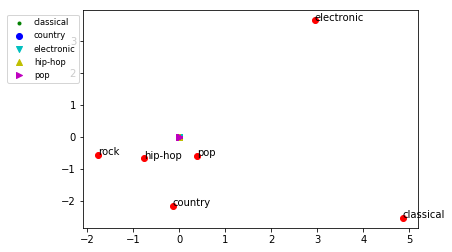

In [81]:
yhat = model.predict(X_validation)


# validaiton_embeddings = regression_based.predict(X_validation)

targets_embeddings = [wordvec['country']]

targets_embeddings = np.array(targets_embeddings, dtype=np.float32)

from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cosine
# Y_pred_validation = []
# for i in validaiton_embeddings:
#     cos = []
#     for j in targets_embeddings:
#         val = cosine(i,j)
#         cos.append(val)
#     Y_pred_validation.append(np.argmax(cos))
#
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(list(wordvec.values()),[0,1,2,3,4,5])
Y_pred_validation = neigh.predict(yhat)
# print Y_2_validation
# print Y_pred_validation
# print (accuracy_score(Y_validation.reshape, Y_pred_validation))
# print (linear_kernel(Y_validation, Y_pred_validation))
train['Genre'] = train['Genre'].replace('classical',0)
train['Genre'] = train['Genre'].replace('country',1)
train['Genre'] = train['Genre'].replace('electronic',2)
train['Genre'] = train['Genre'].replace('hip-hop',3)
train['Genre'] = train['Genre'].replace('pop',4)
train['Genre'] = train['Genre'].replace('rock',5)

test['Genre'] = test['Genre'].replace('classical',0)
test['Genre'] = test['Genre'].replace('country',1)
test['Genre'] = test['Genre'].replace('electronic',2)
test['Genre'] = test['Genre'].replace('hip-hop',3)
test['Genre'] = test['Genre'].replace('pop',4)
test['Genre'] = test['Genre'].replace('rock',5)


from sklearn.decomposition import PCA
pca = PCA(2)
class_list = list(wordvec.values())
class_list.extend(yhat)
class_list = np.array(class_list).astype(float)
total_list = pca.fit_transform(class_list)
tx = [row for row, col in total_list[:6]]
ty = [col for row, col in total_list[:6]]
x_t=[]
y_t=[]
from matplotlib.font_manager import FontProperties
for j in range(6):
    x_t.append([row for i,(row, col) in enumerate(total_list[6:]) if train['Genre'].iloc[i] == j])  #위의 예측부를 바꿔줬다면 여기도 수정해야함 ex) X_train->X_8_train으로 바궛다면 Y_8_train[i]로
    y_t.append([col for i, (row, col) in enumerate(total_list[6:]) if train['Genre'].iloc[i] == j]) #위의 예측부를 바꿔줬다면 여기도 수정해야함
x_t.pop(1)
y_t.pop(1)
marker = ['.','o','v','^','>','<','s','p','*','h']   #마커랑 컬러 바꾸고싶다면..여기를 수정
colors = ['g','b','c','y','m','g','b','c','y','m']
for j in range(5):
    plt.scatter(x_t[j],y_t[j],marker=marker[j],color = colors[j],label=classes[j])
fontP = FontProperties()
fontP.set_size('small')
plt.legend(bbox_to_anchor=(0,1), loc='upper right',prop=fontP)
# plt.scatter(x_1,y_1,color='b')
# plt.scatter(x_4,y_4, color = 'y')
plt.scatter(tx,ty,color='r')
for i, txt in enumerate(classes):
    plt.annotate(txt,(tx[i],ty[i]))

plt.show()

In [30]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))